# Beta Series Analysis
Running beta series analysis to extract coupling between amygdala and relevant ROIs
- Hippocampus
- vmPFC
- SmCortex

Studies show it is better fitted for event-related design (while ppi better in block design)

In [11]:
import pandas as pd
import numpy as np
import glob
import os

import seaborn as sns


import matplotlib.pyplot as plt
from nilearn import image, plotting

from nilearn.datasets import fetch_language_localizer_demo_dataset
from nilearn.glm.first_level import FirstLevelModel, first_level_from_bids, make_first_level_design_matrix

In [7]:
# get relevant subjects first
df = pd.read_csv('../scr_amg_hipp_all.csv')
subject_list = df['sub'].unique()

In [8]:
# Load the neuroimaging data and event file
fmri_filename = '/gpfs/gibbs/pi/levy_ifat/Nachshon/shared/reversal/fmriprep/sub-048/ses-1/func/sub-048_ses-1_task-552_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz'
event_file = '/gpfs/gibbs/pi/levy_ifat/Or/RV_FSL/eventfiles/sub-048.csv'
regressors = '/gpfs/gibbs/pi/levy_ifat/Nachshon/shared/reversal/fmriprep/sub-048/ses-1/func/sub-048_ses-1_task-552_desc-confounds_regressors.csv'
# Load the event file as a pandas DataFrame
events_df = pd.read_csv(event_file)

In [18]:
# Create a design matrix from the event file
design_matrix = make_first_level_design_matrix(
    events=events_df,
    hrf_model='spm',
    drift_model=None
)

TypeError: make_first_level_design_matrix() missing 1 required positional argument: 'frame_times'

In [19]:
model = FirstLevelModel(t_r =2)
sub048 = model.fit(fmri_filename, events_df)
                    

In [22]:
fig, ax = plt.subplots(figsize=(5, 10))
plotting.plot_design_matrix(sub048.design_matrices_[0], ax=ax)
fig.show()

In [55]:
# generate situation in which we make each trial a special event (unlike standard GLM)
lsa_events_df

,trial_type,onset,duration
0,CSplusUS1__001,0,4
1,CSminus1__001,16,4
2,CSplus1__001,32,4
3,CSplusUS1__002,48,4
4,CSminus1__002,64,4
...,...,...,...
64,CSminus2__014,1024,4
65,CSplus2__015,1040,4
66,CSminus2__015,1056,4
67,CSplus2__016,1072,4


In [59]:
# Transform the DataFrame for LSA
lsa_events_df = events_df.copy()
conditions = lsa_events_df["trial_type"].unique()

condition_counter = {c: 0 for c in conditions}
for i_trial, trial in lsa_events_df.iterrows():
    trial_condition = trial["trial_type"]
    condition_counter[trial_condition] += 1
    # We use a unique delimiter here (``__``) that shouldn't be in the
    # original condition names
    trial_name = f"{trial_condition}__{i_trial:02d}" # generate trial name with trial number (for use later)
    lsa_events_df.loc[i_trial, "trial_type"] = trial_name

In [61]:
lsa_glm = FirstLevelModel(t_r = 2)

In [62]:
lsa_glm.fit(fmri_filename, lsa_events_df)

FirstLevelModel(t_r=2)

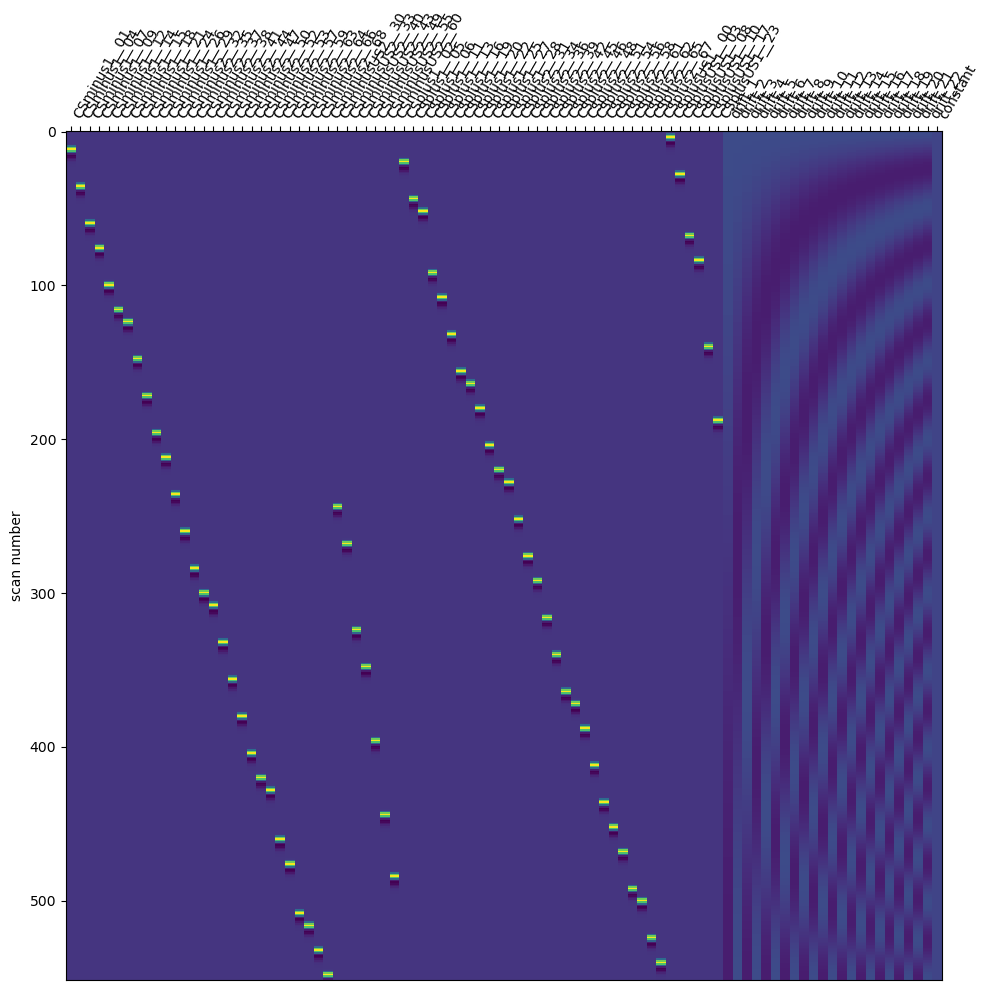

In [63]:
fig, ax = plt.subplots(figsize=(10, 10))
plotting.plot_design_matrix(lsa_glm.design_matrices_[0], ax=ax)
fig.show()

In [ ]:
# need to think how to combine this with the PE later on. 
#Can I extract coupling measure per trial? so I can use it later on. Or I'll have to run the PE as a parameter in the design matrix

In [54]:
lsa_beta_maps = {}

trialwise_conditions = lsa_events_df["trial_type"].unique()

for condition in trialwise_conditions:
    beta_map = lsa_glm.compute_contrast(condition, output_type="effect_size")
    # Drop the trial number from the condition name to get the original name
   # print(condition)
    #condition_name = condition#.split("__")[0]
    lsa_beta_maps[condition] = beta_map

In [54]:
# We can concatenate the lists of 3D maps into a single 4D beta series for
# each condition, if we want
lsa_beta_maps = {
    name: image.concat_imgs(maps) for name, maps in lsa_beta_maps.items()
}

CSplusUS1__001
CSminus1__001
CSplus1__001
CSplusUS1__002
CSminus1__002
CSplus1__002
CSplus1__003
CSminus1__003
CSplusUS1__003
CSminus1__004
CSplusUS1__004
CSplus1__004
CSminus1__005
CSplus1__005
CSminus1__006
CSminus1__007
CSplus1__006
CSplusUS1__005
CSminus1__008
CSplus1__007
CSplus1__008
CSminus1__009
CSplus1__009
CSplusUS1__006
CSminus1__010
CSplus1__010
CSminus1__011
CSplus1__011
CSplus1__012
CSminus1__012
CSminusUS2__001
CSplus2__001
CSminus2__001
CSminusUS2__002
CSplus2__002
CSminus2__002
CSplus2__003
CSminus2__003
CSminus2__004
CSplus2__004
CSminusUS2__003
CSminus2__005
CSplus2__005
CSminusUS2__004
CSminus2__006
CSplus2__006
CSplus2__007
CSminus2__007
CSplus2__008
CSminusUS2__005
CSminus2__008
CSplus2__009
CSminus2__009
CSminus2__010
CSplus2__010
CSminusUS2__006
CSplus2__011
CSminus2__011
CSplus2__012
CSminus2__012
CSminusUS2__007
CSplus2__013
CSplus2__014
CSminus2__013
CSminus2__014
CSplus2__015
CSminus2__015
CSplus2__016
CSminus2__016


TypeError: Cannot slice image objects; consider using `img.slicer[slice]` to generate a sliced image (see documentation for caveats) or slicing image array data with `img.dataobj[slice]` or `img.get_fdata()[slice]`